In [2]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets

In [3]:
function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

load_model (generic function with 1 method)

In [4]:
epoch_to_load = 10
encoder_mu, encoder_logvar, decoder = load_model("result",epoch_to_load);

Loading model...Done


In [5]:
function PLUGIn(G,y, max_iter, stepsize, tolerance, out_toggle)
    
  (_, z_dim) = size(Flux.params(G[1])[1]);
  W = I(z_dim)

  #normalize the weights of the network
  for i in 1:length(G)
      _, s, _ = svd(Flux.params(G[i])[1])
      W = Flux.params(G[i])[1] * W /s[1]
  end

  # _, s, _ = svd(W)

  z = randn(z_dim)
  iter = 1
  succ_error = 1

  while iter <= max_iter && succ_error > tolerance
    
    # d gives the PLUGIn direction
    d = W'*(G(z) - y)
    z -= stepsize * d
    succ_error = norm(stepsize * d)
    println(norm(d))
    if iter % out_toggle == 0  
        println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
    end
    iter += 1
  end
  println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")

  return z
end

PLUGIn (generic function with 1 method)

In [6]:
#setup a synthetic problem
G = Chain(
    Dense(20, 500, relu, bias = false; initW =(out,in) ->  randn(500, 20)/sqrt(500)),
    Dense(500, 500, relu, bias = false; initW =(out,in) -> randn(500, 500)/sqrt(500)),
    Dense(500, 784, relu, bias = false; initW =(out,in) -> randn(784, 500)/sqrt(784))
)

z = randn(20)
y = G(z) + 1e-14 * randn(784)

stepsize = 20
tolerance = 1e-14
max_iter = 10000
out_toggle = 1000
z_rec = PLUGIn(G,y, max_iter, stepsize, tolerance, 10000)
error = norm(z - z_rec)
println("recovery error: $error")

0.2103187483942702
0.060320936253559124
0.02568229254166786
0.013677555576856666
0.009227644780357527
0.006579079900312183
0.0053806905753390035
0.004424268845908971
0.0036434380716889453
0.0030003633682877534
0.002476473084731077
0.0020744240023533467
0.0017593922011000572
0.0014912408398006902
0.0012525829881454803
0.001049887697452805
0.0008707183549653343
0.0007165411019709126
0.0005865264585301337
0.0004788258466270651
0.00039038985281926935
0.0003207984409565375
0.0002619845587458013
0.00021330994370982704
0.00017320332066256605
0.00014038426460119888
0.00011385192333144214
9.220938013021935e-5
7.434144138561317e-5
5.964794427548756e-5
4.774276321795975e-5
3.813772948555408e-5
3.0423169227037636e-5
2.424664402017128e-5
1.9310988845873033e-5
1.537134176462985e-5
1.2228901733797924e-5
9.723673973650989e-6
7.727425593486787e-6
6.137565907737e-6
4.872063593015253e-6
3.8653359230765625e-6
3.0649549411372717e-6
2.429017900873903e-6
1.924047059677963e-6
1.5233100578488086e-6
1.205474613

In [10]:
function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

# experiments with MNIST dataset
epoch_to_load = 20
# Load the model and test set loader
encoder_mu, encoder_logvar, decoder = load_model("result", epoch_to_load)


# pick a image in MNIST to denoise
num = 1
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x = x_batch[:,i]
y = x 

stepsize = .4
tolerance = 1e-7
max_iter = 1000
out_toggle = 100
z_rec = PLUGIn(decoder, y, max_iter, stepsize, tolerance, 1000001)
error = norm(x - decoder(z_rec))
println("recovery error: $error")


Loading model...Done
0.08386444918278171
0.08107251555486863
0.07814482611396059
0.07541354600228042
0.07292958481351378
0.07058635574422491
0.0684155054464371
0.06641873560479114
0.0645836520855735
0.06289142068032556
0.06133285012090278
0.0598911023556262
0.05855496650191205
0.05731361124076422
0.05615035461760959
0.0550567755539485
0.054021954734889195
0.0530395127712578
0.051982726275923825
0.05096571353975343
0.050010447459710415
0.04910716923523119
0.0482473199789519
0.04742515943340798
0.04663853278124243
0.04587124656949822
0.045085895109186154
0.0443141351428304
0.043574382450886
0.04282042923625241
0.04207490409740552
0.04136752613598774
0.040696469462293265
0.04005796232586639
0.03945729270431928
0.03892859074177959
0.038447339142726585
0.037992237929314186
0.03756479922266943
0.03716292655998672
0.036778504398931364
0.03641136130617854
0.03606053436369405
0.035726049834541064
0.03540673984898098
0.03510602273967252
0.034816056689321744
0.034489584877004285
0.034179527620551

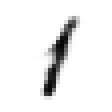

In [11]:
colorview(Gray, reshape(decoder(z_rec), 28,28)' )

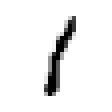

In [12]:
colorview(Gray, reshape(x, 28,28)' )

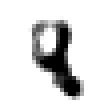

In [25]:
colorview(Gray, reshape(decoder(rand(20)) ,28, 28)' )

In [37]:
_, s, _ = svd(Flux.params(decoder[3])[1]);
s

500-element Vector{Float32}:
 4.577261
 3.297501
 3.1512952
 3.0911386
 3.0140564
 2.894886
 2.8527446
 2.781469
 2.721854
 2.6966097
 2.660559
 2.6399364
 2.603402
 ⋮
 1.6984431f-7
 1.6984431f-7
 1.6984431f-7
 1.6984431f-7
 1.6984431f-7
 1.6984431f-7
 1.6984431f-7
 1.3442524f-7
 1.06851246f-7
 9.012931f-8
 5.805154f-8
 2.9253819f-8